In [112]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from datetime import datetime
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier,HistGradientBoostingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
import glob
import os
import pandas as pd
from utils.data import *
from utils.evaluation import *

df = pd.read_csv("ntu-fintech-hw1-new/train.csv", index_col=["index"])
df.head(1)

,age,euducation_level,job,marital,have_credit_card,have_housing_loan,have_personal_loan,connect_method,previous_connect_month,previous_connect_weekday,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,last_campaign_outcomes,employment_rate,consumer_price_index,consumer_confidence_index,label
index,,,,,,,,,,,,,,,,,,
0,39.0,high,employment,married,no,no,no,cellular,November,Tuesday,1.0,-1.0,0.0,nonexistent,59.9,93.2,-42.0,0


In [114]:
# preprocessing
## NaN
#df = df.dropna(axis=0)
#df = fill_nan_with_mean_most(df)
df = df.fillna(df.rolling(2, min_periods=1).sum().mean())


## label
#df = labeling(df)
for feature in df.columns:
    df[feature] = labelencoder.fit_transform(df[feature])


#df =  preprocessing_only_label(df)
#X =  preprocessing_onehot(X)
#df =  preprocessing_mean_mode(df)

X = df.drop(['label'],axis=1)
y = df['label']
print(X.shape, y.shape)
X.head(1)

(20000, 17) (20000,)


,age,euducation_level,job,marital,have_credit_card,have_housing_loan,have_personal_loan,connect_method,previous_connect_month,previous_connect_weekday,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,last_campaign_outcomes,employment_rate,consumer_price_index,consumer_confidence_index
index,,,,,,,,,,,,,,,,,
0,21,0,0,1,0,0,0,0,7,3,0,1,0,1,7,11,7


In [68]:
ct = np.unique(y, return_counts=True)[1]
print(ct[0]/ct.sum(), ct[1]/ct.sum())

0.84915 0.15085


In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head(1)

(6000, 17) (14000, 17) (6000,) (14000,)


,age,euducation_level,job,marital,have_credit_card,have_housing_loan,have_personal_loan,connect_method,previous_connect_month,previous_connect_weekday,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,last_campaign_outcomes,employment_rate,consumer_price_index,consumer_confidence_index
index,,,,,,,,,,,,,,,,,
12950,39,0,0,1,0,0,0,0,0,1,1,1,0,1,3,10,3


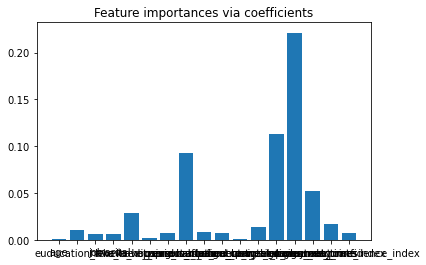

In [116]:
from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(X_train, y_train)
importance = np.abs(lasso.coef_)
threshold = np.sort(importance)[-17] +0.001
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)
plt.bar(height=importance, x=X_train.columns)
plt.title("Feature importances via coefficients")
plt.show()

In [117]:
np.sort(importance)

array([0.00044685, 0.00065276, 0.00213552, 0.00637511, 0.00645856,
       0.00757491, 0.00759717, 0.00761405, 0.00796632, 0.01098545,
       0.01376085, 0.01656445, 0.02918357, 0.05271984, 0.09272907,
       0.11345813, 0.22103433])

In [118]:
np.sort(importance)[-17] 

0.0004468505512370985

In [119]:
threshold

0.0014468505512370985

In [120]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [121]:
#X_train = X
#y_train=y
print(X_train.shape)

(6000, 17)


In [123]:

params={}
"""params={"LogisticRegression__C":np.logspace(-3,3,7), "LogisticRegression__penalty":["l1","l2"]}# l1 lasso l2 ridge"""
"""params ={'LGBMClassifier__num_leaves': sp_randint(6, 50), 
             'LGBMClassifier__min_child_samples': np.linspace(90,150,10).astype("int"),#sp_randint(100, 500), 
             'LGBMClassifier__min_child_weight': [1e-7, 1e-4, 1e-5, 1e-3],
             'LGBMClassifier__subsample': np.linspace(0.1,0.6,10), 
             'LGBMClassifier__colsample_bytree': sp_uniform(loc=0.5, scale=0.6),
             'LGBMClassifier__reg_alpha': [0,1,2,3,4,5],
             'LGBMClassifier__reg_lambda': [10,15,20,25,30]}"""
"""params ={'LGBMClassifier__num_leaves': sp_randint(6, 50), 
             'LGBMClassifier__min_child_samples': sp_randint(100, 500), 
             'LGBMClassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'LGBMClassifier__subsample': sp_uniform(loc=0.2, scale=0.9), 
             'LGBMClassifier__colsample_bytree': sp_uniform(loc=0.5, scale=0.6),
             'LGBMClassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'LGBMClassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
            'LGBMClassifier__learning_rate':[1e-2, 1e-3, 1e-4, 1e-5],
           'LGBMClassifier__boosting_type':["gbdt", "dart"],
          
        }"""

"""params={}"""

"""params ={'LGBMClassifier__num_leaves': np.linspace(1,100,20).astype(int), 
             'LGBMClassifier__min_child_samples':  np.linspace(10,3000,20).astype(int), 
             'LGBMClassifier__min_child_weight': np.linspace(1e-9,1e9,20),
             'LGBMClassifier__subsample': sp_uniform(loc=0.3, scale=0.5), 
             'LGBMClassifier__colsample_bytree': sp_uniform(loc=0.5, scale=0.6),
             'LGBMClassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'LGBMClassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}"""
"""params = {
        'XGBClassifier__min_child_weight': np.linspace(1e-2,1e2,10),
        'XGBClassifier__gamma': [0.01, 0.25, 0.5, 1, 1.25, 1.5, 2,3],
        'XGBClassifier__subsample': np.linspace(0.2,1,10),
        'XGBClassifier__colsample_bytree': np.linspace(0.2,1,10),
        'XGBClassifier__max_depth': [2, 3, 4, 5, 6, 7,8],
        'XGBClassifier__early_stopping_rounds':[10,15,20, 30],
        'XGBClassifier__eta':[2,1.5, 1,0.75,0.5,0.25, 0.01],
        'XGBClassifier__n_estimators':np.linspace(100,500,20).astype("int")
        }"""
"""params = {'SVC__kernel':['rbf'],
              'SVC__C':[0.1,1,100,10e5], 
              'SVC__gamma':np.linspace(1e-5,0.5, 5),
             'SVC__probability':[True],
             }"""
"""params = { 
    'RandomForestClassifier__n_estimators': [100, 200,300, 500,1000],
    'RandomForestClassifier__max_features': ['auto', 'sqrt', 'log2'],
    'RandomForestClassifier__max_depth' : [2,3,5,7],
    'RandomForestClassifier__criterion' :['gini', 'entropy']
}"""
"""params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error'}"""
"""params = {
    "SGDClassifier__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "SGDClassifier__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "SGDClassifier__penalty" : ["l2", "l1", "none"],
}"""
"""params = {'AdaBoostClassifier__n_estimators':[500, 1000, 1500, 2000], 
              'AdaBoostClassifier__learning_rate':[0.05, 0.1, 0.15, 0.2]}"""
"""params = {
 "HistGradientBoostingClassifier__max_iter": [1000,1200,1500],
 "HistGradientBoostingClassifier__learning_rate": [0.1],
 "HistGradientBoostingClassifier__max_depth" : [25, 50, 75],
 "HistGradientBoostingClassifier__l2_regularization": [1.5],
 "HistGradientBoostingClassifier__scoring": ["f1_micro"],
 "HistGradientBoostingClassifier__random_state" : [0],
 }"""
"""params = {
    "GradientBoostingClassifier__loss":["deviance"],
    "GradientBoostingClassifier__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "GradientBoostingClassifier__min_samples_split": np.linspace(0.1, 0.5, 12),
    "GradientBoostingClassifier__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "GradientBoostingClassifier__max_depth":[3,5,8],
    "GradientBoostingClassifier__max_features":["log2","sqrt"],
    "GradientBoostingClassifier__criterion": ["friedman_mse",  "mae"],
    "GradientBoostingClassifier__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "GradientBoostingClassifier__n_estimators":[10]
    }"""

pipe = Pipeline(steps=[
                        
                        #('KMeans', KMeans()),
                        #('sampling', SMOTE()),
                        #('sampling', ADASYN()),
                        ('sampling', RandomUnderSampler()),
                        ('scaler', StandardScaler()),
                        #('feature_selection', SelectFromModel(LogisticRegression())),
                        #('feature_selection', sfm),
                        #('PCA', PCA()),
                        #('feature_selection', PolynomialFeatures()),
                        ('XGBClassifier', XGBClassifier())
                        #('SVC', SVC()),
                        #('RandomForestClassifier', RandomForestClassifier()),
                        #('LogisticRegression', LogisticRegression()),
                        #('LGBMClassifier', LGBMClassifier()),
                        #('calibrator', calibrator()),
                        #("stack", clf_stack),
                        #('BaggingClassifier', BaggingClassifier(LGBMClassifier())),
                        #('ExtraTreesClassifier', ExtraTreesClassifier()),
                        #('AdaBoostClassifier', AdaBoostClassifier()),
                        #('GradientBoostingClassifier', GradientBoostingClassifier()),
                        #('HistGradientBoostingClassifier', HistGradientBoostingClassifier()),
                        #('SGDClassifier', SGDClassifier()),
                        #('MLPClassifier', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, early_stopping=True)),
                        
                        ])
                        


folds = 3
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(pipe, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[22:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 1.05 seconds.


In [108]:
random_search.best_params_

{}

In [124]:
model = random_search.best_estimator_
#model = calibration_clf
y_pred = model.predict(X_test)
score = myScore(y_pred, y_test.to_numpy()) 
score

0.7166493641318453

myScore: 0.7166493641318453
[22:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:11] WARNING: C:/Users/Administrator

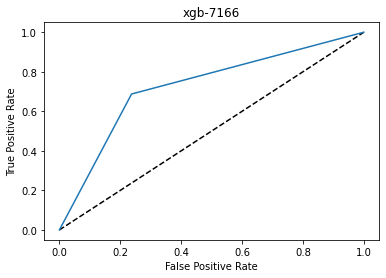

In [125]:
from joblib import dump, load
import json
score = myScore(y_pred, y_test.to_numpy())
print("myScore:", score)

cm ,report, cv_score, roc = result(model, X_test, y_test, y_pred)
save = {}
save["myScore"] = score
save["cm"] = str(cm)
save["report"] = report
save["cv_score"] = cv_score
save["roc"] = roc

print(cm)
print(roc)
filename = "xgb-7166"
dump(model, "output/models/new_test/"+filename+".joblib") 
with open("log/"+filename+'.json', 'w') as fp:
    json.dump(save, fp)
plt.title(filename)
plt.savefig("log/img/"+filename+'.png')

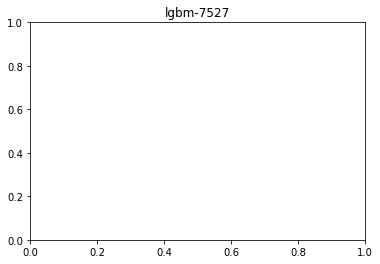

In [117]:
model1 = load("output/models/lgbm-7747.joblib")
model2 = load("output/models/rf-7357.joblib")


In [118]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
models = [("m1", model1),("m2", model2)]
clf2 = VotingClassifier(estimators = models, voting='soft') 
clf2.fit(X_train, y_train)

VotingClassifier(estimators=[('m1',
                              Pipeline(steps=[('sampling',
                                               RandomUnderSampler()),
                                              ('scaler', StandardScaler()),
                                              ('LGBMClassifier',
                                               LGBMClassifier(colsample_bytree=0.8911072339216042,
                                                              min_child_samples=197,
                                                              min_child_weight=10.0,
                                                              num_leaves=41,
                                                              reg_alpha=0.1,
                                                              reg_lambda=0,
                                                              subsample=0.40688973304147463))])),
                             ('m2',
                              Pipeline(steps=[('sampling',
  

In [119]:
model = clf2
y_pred = model.predict(X_test)
score = myScore(y_pred, y_test.to_numpy())
score

0.7676678445229682

myScore: 0.7676678445229682


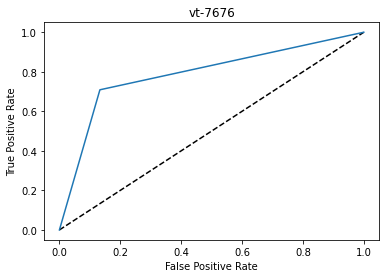

In [120]:
from joblib import dump, load
import json
score = myScore(y_pred, y_test.to_numpy())
print("myScore:", score)

cm ,report, cv_score = result(model, X_test, y_test, y_pred)
save = {}
save["myScore"] = score
save["cm"] = str(cm)
save["report"] = report
save["cv_score"] = cv_score


filename = "vt-7676"
dump(model, "output/models/"+filename+".joblib") 
with open("log/"+filename+'.json', 'w') as fp:
    json.dump(save, fp)
plt.title(filename)
plt.savefig("log/img/"+filename+'.png')

In [110]:
from sklearn.ensemble import BaggingClassifier
logbagClf = BaggingClassifier(LogisticRegression(random_state=0, solver='lbfgs'), n_estimators = 100, oob_score = True, random_state = 90)
logbagClf.fit(X_train, y_train)


BaggingClassifier(base_estimator=LogisticRegression(random_state=0),
                  n_estimators=100, oob_score=True, random_state=90)

In [21]:

estimators = [
    ("mlp", MLPClassifier(random_state=1)),
    ("lgbm", LGBMClassifier(random_state=1)),
    
]
clf_stack = StackingClassifier(estimators=estimators, final_estimator=SVC())
clf_stack.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=1)),
                               ('mlp', MLPClassifier(random_state=1))],
                   final_estimator=SVC())

In [22]:
model = clf
y_pred = model.predict(X_test)
score = myScore(y_pred, y_test.to_numpy())
score

0.6530352870813397

In [ ]:


#('XGBClassifier', XGBClassifier())
#('SVC', SVC()),
#('RandomForestClassifier', RandomForestClassifier()),
#('LogisticRegression', LogisticRegression()),
#('LGBMClassifier', LGBMClassifier()),
#('BaggingClassifier', BaggingClassifier(KNeighborsClassifier(),max_samples=0.9, max_features=0.5)),
#('ExtraTreesClassifier', ExtraTreesClassifier()),
#('AdaBoostClassifier', AdaBoostClassifier()),
('GradientBoostingClassifier', GradientBoostingClassifier()),
#('HistGradientBoostingClassifier', HistGradientBoostingClassifier()),
#('SGDClassifier', SGDClassifier()),
#('MLPClassifier', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, early_stopping=True)),

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')

from sklearn.model_selection import GridSearchCV
clf1 = XGBClassifier(random_state=1)
clf2 = SVC(random_state=1, probability=True)
clf3 = RandomForestClassifier()
clf4 = LGBMClassifier(random_state=1)
clf5 = BaggingClassifier(random_state=1)
clf6 = ExtraTreesClassifier(random_state=1)
clf7 = LogisticRegression(random_state=1)
clf8 = AdaBoostClassifier(random_state=1)
clf9 = GradientBoostingClassifier(random_state=1)
clf10 = HistGradientBoostingClassifier(random_state=1)
clf11 = calibrator#SGDClassifier(random_state=1, class_weight='balanced', loss='hinge')
clf12 = MLPClassifier(random_state=1)
models = [('clf1', clf1), ('clf2', clf2),('clf3', clf3),('clf4', clf4),('clf5', clf5),('clf6', clf6),('clf7', clf7),('clf8', clf8),('clf9', clf9),('clf10', clf10),('clf11', clf11),('clf12', clf12)]
#models = [('clf1', clf1), ('clf2', clf2),('clf3', clf3)]

eclf = VotingClassifier(
    estimators=models,
    voting='soft'
)

#params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}


grid = GridSearchCV(estimator=eclf, param_grid=params, cv=3)
folds = 3
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(eclf, param_distributions={}, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
model = random_search.best_estimator_
y_pred = model.predict(X_test)
score = myScore(y_pred, y_test.to_numpy()) 
score

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

In [60]:
"""lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_train, y_train)
calibration_clf = CalibratedClassifierCV(random_search.best_estimator_ , cv=5)
calibration_clf.fit(X_train, y_train)
"""

"lr = SGDClassifier(loss='hinge',class_weight='balanced')\nclf =lr.fit(X_train, y_train)\ncalibration_clf = CalibratedClassifierCV(random_search.best_estimator_ , cv=5)\ncalibration_clf.fit(X_train, y_train)\n"